# Advanced Document Parsing For Enterprises

## Introduction

The bread and butter of natural language processing technology is text. Once we can reduce a set of data into text, we can do all kinds of things with it: question answering, summarization, classification, sentiment analysis, searching and indexing, and more.
<br>
<br>
In the context of enterprise Retrieval Augmented Generation (RAG), the information is often locked in complex file types such as PDFs. These formats are made for sharing information between humans, but not so much with language models.
<br>
<br>
In this notebook, we will use a real-world pharmaceutical drug label to test out various performant approaches to parsing PDFs. This will allow us to use [Cohere's Command-R model](https://txt.cohere.com/command-r/) in a RAG setting to answer questions and asks about this label, such as "I need a succinct summary of the compound name, indication, route of administration, and mechanism of action of" a given pharmaceutical.
<br>
<br>
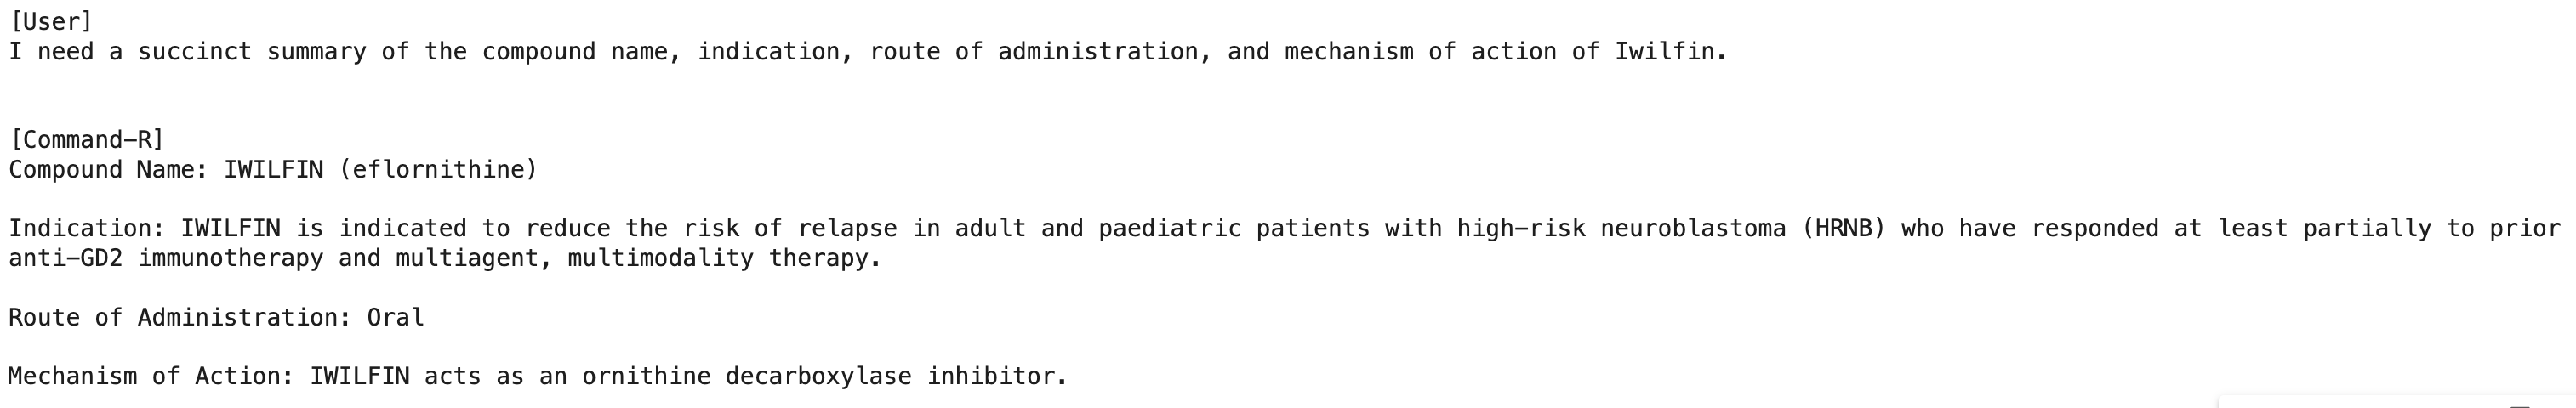

<a name="top"></a>
## PDF Parsing

We will go over five proprietary as well as open source options for processing PDFs. The parsing mechanisms demonstrated in the following sections are
- [Google Document AI](#gcp)
- [AWS Textract](#aws)
- [Unstructured.io](#unstructured)
- [LlamaParse](#llama)
- [pdf2image + pytesseract](#pdf2image)

By way of example, we will be parsing a [21-page PDF](https://www.accessdata.fda.gov/drugsatfda_docs/label/2023/215500s000lbl.pdf) containing the label for a recent FDA drug approval, the beginning of which is shown below. Then, we will perform a series of basic RAG tasks with our different parsings and evaluate their performance.

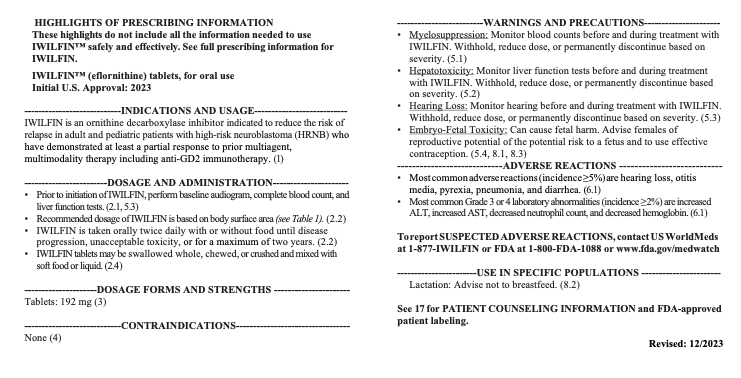

## Getting Set Up

Before we dive into the technical weeds, we need to set up the notebook's runtime and filesystem environments. The code cells below do the following:
- Install required libraries
- Confirm that data dependencies from the GitHub repo have been downloaded. These will be under `data/document-parsing` and contain the following:
    - the PDF document that we will be working with, `fda-approved-drug.pdf` (this can also be found here: https://www.accessdata.fda.gov/drugsatfda_docs/label/2023/215500s000lbl.pdf)
    - precomputed parsed documents for each parsing solution. While the point of this notebook is to illustrate how this is done, we provide the parsed final results to allow readers to skip ahead to the RAG section without having to set up the required infrastructure for each solution.)
- Add utility functions needed for later sections

In [ ]:
%%capture
! sudo apt install tesseract-ocr poppler-utils
! pip install cohere fsspec hnswlib google-cloud-documentai google-cloud-storage boto3 langchain-text-splitters llama_parse pytesseract pdf2image pandas


In [ ]:
data_dir = "data/document-parsing"
source_filename = "example-drug-label"
extension = "pdf"

In [ ]:
from pathlib import Path

sources = ["gcp", "aws", "unstructured-io", "llamaparse-text", "llamaparse-markdown", "pytesseract"]

filenames = ["{}-parsed-fda-approved-drug.txt".format(source) for source in sources]
filenames.append("fda-approved-drug.pdf")

for filename in filenames:   
    file_path = Path(f"{data_dir}/{filename}")
    if file_path.is_file() == False:
        print(f"File {filename} not found at {data_dir}!")

### Utility Functions
Make sure to include the notebook's utility functions in the runtime.

In [ ]:
def store_document(path: str, doc_content: str):
    with open(path, 'w') as f:
      f.write(doc_content)

In [ ]:
import json

def insert_citations_in_order(text, citations, documents):
    """
    A helper function to pretty print citations.
    """

    citations_reference = {}
    for index, doc in enumerate(documents):
        citations_reference[index] = doc

    offset = 0
    # Process citations in the order they were provided
    for citation in citations:
        # Adjust start/end with offset
        start, end = citation['start'] + offset, citation['end'] + offset
        citation_numbers = []
        for doc_id in citation["document_ids"]:
            for citation_index, doc in citations_reference.items():
                if doc["id"] == doc_id:
                    citation_numbers.append(citation_index)
        references = "(" + ", ".join("[{}]".format(num) for num in citation_numbers) + ")"
        modification = f'{text[start:end]} {references}'
        # Replace the cited text with its bolded version + placeholder
        text = text[:start] + modification + text[end:]
        # Update the offset for subsequent replacements
        offset += len(modification) - (end - start)

    # Add the citations at the bottom of the text
    text_with_citations = f'{text}'
    citations_reference = ["[{}]: {}".format(x["id"], x["text"]) for x in citations_reference.values()]

    return text_with_citations, "\n".join(citations_reference)

In [ ]:
def format_docs_for_chat(documents):
  return [{"id": str(index), "text": x} for index, x in enumerate(documents)]

## Document Parsing Solutions

For demonstration purposes, we have collected and saved the parsed documents from each solution in this notebook. Skip to the [next section](#document-questions) to run RAG with Command-R on the pre-fetched versions. You can find all parsed resources in detail at the link [here](https://github.com/gchatz22/temp-cohere-resources/tree/main/data).

<a name="gcp"></a>
### Solution 1: Google Cloud Document AI [[Back to Solutions]](#top)

Document AI helps developers create high-accuracy processors to extract, classify, and split documents.
<br>
External documentation: https://cloud.google.com/document-ai

#### Parsing the document

The following block can be executed in one of two ways
1. Inside a Google Vertex AI environment
  - No authentication is needed
2. Inside the notebook
  - Authentication needed
  - There are pointers inside the code on which lines to uncomment in order to achieve that
<br>
**Note: You can skip to the next block if you want to use the pre-existing parsed version.**

In [ ]:
"""
Extracted from https://cloud.google.com/document-ai/docs/samples/documentai-batch-process-document
"""

import re
from typing import Optional

from google.api_core.client_options import ClientOptions
from google.api_core.exceptions import InternalServerError
from google.api_core.exceptions import RetryError
from google.cloud import documentai  # type: ignore
from google.cloud import storage

project_id = ""
location = ""
processor_id = ""
gcs_output_uri = ""
# credentials_file = "populate if you are running in a non Vertex AI environment."
gcs_input_prefix = ""


def batch_process_documents(
    project_id: str,
    location: str,
    processor_id: str,
    gcs_output_uri: str,
    gcs_input_prefix: str,
    timeout: int = 400
) -> None:
    parsed_documents = []

    # Client configs
    opts = ClientOptions(api_endpoint=f"{location}-documentai.googleapis.com")
    # With credentials
    # opts = ClientOptions(api_endpoint=f"{location}-documentai.googleapis.com", credentials_file=credentials_file)

    client = documentai.DocumentProcessorServiceClient(client_options=opts)
    processor_name = client.processor_path(project_id, location, processor_id)

    # Input storage configs
    gcs_prefix = documentai.GcsPrefix(gcs_uri_prefix=gcs_input_prefix)
    input_config = documentai.BatchDocumentsInputConfig(gcs_prefix=gcs_prefix)

    # Output storage configs
    gcs_output_config = documentai.DocumentOutputConfig.GcsOutputConfig(gcs_uri=gcs_output_uri, field_mask=None)
    output_config = documentai.DocumentOutputConfig(gcs_output_config=gcs_output_config)
    storage_client = storage.Client()
    # With credentials
    # storage_client = storage.Client.from_service_account_json(json_credentials_path=credentials_file)

    # Batch process docs request
    request = documentai.BatchProcessRequest(
        name=processor_name,
        input_documents=input_config,
        document_output_config=output_config,
    )

    # batch_process_documents returns a long running operation
    operation = client.batch_process_documents(request)

    # Continually polls the operation until it is complete.
    # This could take some time for larger files
    try:
        print(f"Waiting for operation {operation.operation.name} to complete...")
        operation.result(timeout=timeout)
    except (RetryError, InternalServerError) as e:
        print(e.message)

    # Get output document information from completed operation metadata
    metadata = documentai.BatchProcessMetadata(operation.metadata)
    if metadata.state != documentai.BatchProcessMetadata.State.SUCCEEDED:
        raise ValueError(f"Batch Process Failed: {metadata.state_message}")

    print("Output files:")
    # One process per Input Document
    for process in list(metadata.individual_process_statuses):
        matches = re.match(r"gs://(.*?)/(.*)", process.output_gcs_destination)
        if not matches:
            print("Could not parse output GCS destination:", process.output_gcs_destination)
            continue

        output_bucket, output_prefix = matches.groups()
        output_blobs = storage_client.list_blobs(output_bucket, prefix=output_prefix)

        # Document AI may output multiple JSON files per source file
        # (Large documents get split in multiple file "versions" doc --> parsed_doc_0 + parsed_doc_1 ...)
        for blob in output_blobs:
            # Document AI should only output JSON files to GCS
            if blob.content_type != "application/json":
                print(f"Skipping non-supported file: {blob.name} - Mimetype: {blob.content_type}")
                continue

            # Download JSON file as bytes object and convert to Document Object
            print(f"Fetching {blob.name}")
            document = documentai.Document.from_json(blob.download_as_bytes(), ignore_unknown_fields=True)
            # Store the filename and the parsed versioned document content as a tuple
            parsed_documents.append((blob.name.split("/")[-1].split(".")[0], document.text))

    print("Finished document parsing process.")
    return parsed_documents

# Call service
# versioned_parsed_documents = batch_process_documents(
#     project_id=project_id,
#     location=location,
#     processor_id=processor_id,
#     gcs_output_uri=gcs_output_uri,
#     gcs_input_prefix=gcs_input_prefix
# )

In [ ]:
"""
Post process parsed document and store it locally.
Make sure to run in Google Vertex AI environment or include a credentials file.
"""

# from pathlib import Path
# from collections import defaultdict

# parsed_documents = []
# combined_versioned_parsed_documents = defaultdict(list)

# # Assemble versioned documents together ({"doc_name": [(0, doc_content_0), (1, doc_content_1), ...]}).
# for filename, doc_content in versioned_parsed_documents:
#   filename, version = "-".join(filename.split("-")[:-1]), filename.split("-")[-1]
#   combined_versioned_parsed_documents[filename].append((version, doc_content))

# # Sort documents by version and join the content together.
# for filename, docs in combined_versioned_parsed_documents.items():
#   doc_content = " ".join([x[1] for x in sorted(docs, key=lambda x: x[0])])
#   parsed_documents.append((filename, doc_content))

# # Store parsed documents in local storage.
# for filename, doc_content in parsed_documents:
#  file_path = "{}/{}-parsed-{}.txt".format(data_dir, "gcp", source_filename)
#  store_document(file_path, doc_content)

'\nPost process parsed document and store it locally.\nMake sure to run in Google Vertex AI environment or include a credentials file.\n'

#### Visualize the parsed document

In [ ]:
filename = "gcp-parsed-{}.txt".format(source_filename)
with open("{}/{}".format(data_dir, filename), "r") as doc:
    parsed_document = doc.read()

print(parsed_document[:1000])

<a name="aws"></a>
### Solution 2: AWS Textract [[Back to Solutions]](#top)

[Amazon Textract](https://aws.amazon.com/textract/) is an OCR service offered by AWS. It can detect text, forms, tables, and more in PDFs and images. In this section, we go over how to use Textract's asynchronous API.
<br>
<br>

#### Parsing the document

We assume you are working within the AWS ecosystem (from a SageMaker notebook, EC2 instance, a Lambda function, ...) with valid credentials. Much of the code here is from supplemental materials created by AWS and offered here:

- https://github.com/awsdocs/aws-doc-sdk-examples/tree/main/python/example_code/textract
- https://github.com/aws-samples/textract-paragraph-identification/tree/main

At minimum, you will need access to the following AWS resources to get started:

- Textract
- an S3 bucket containing the document(s) to process - in this case, our `example-drug-label.pdf` file
- an SNS topic that Textract can publish to. This is used to send a notification that parsing is complete.
- an IAM role that Textract will assume, granting access to the S3 bucket and SNS topic

First, we bring in the `TextractWrapper` class provided in the [AWS Code Examples repository](https://github.com/awsdocs/aws-doc-sdk-examples/blob/main/python/example_code/textract/textract_wrapper.py). This class makes it simpler to interface with the Textract service.

In [ ]:
# source: https://github.com/awsdocs/aws-doc-sdk-examples/tree/main/python/example_code/textract

# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

"""
Purpose

Shows how to use the AWS SDK for Python (Boto3) with Amazon Textract to
detect text, form, and table elements in document images.
"""

import json
import logging
from botocore.exceptions import ClientError

logger = logging.getLogger(__name__)


# snippet-start:[python.example_code.textract.TextractWrapper]
class TextractWrapper:
    """Encapsulates Textract functions."""

    def __init__(self, textract_client, s3_resource, sqs_resource):
        """
        :param textract_client: A Boto3 Textract client.
        :param s3_resource: A Boto3 Amazon S3 resource.
        :param sqs_resource: A Boto3 Amazon SQS resource.
        """
        self.textract_client = textract_client
        self.s3_resource = s3_resource
        self.sqs_resource = sqs_resource

    # snippet-end:[python.example_code.textract.TextractWrapper]

    # snippet-start:[python.example_code.textract.DetectDocumentText]
    def detect_file_text(self, *, document_file_name=None, document_bytes=None):
        """
        Detects text elements in a local image file or from in-memory byte data.
        The image must be in PNG or JPG format.

        :param document_file_name: The name of a document image file.
        :param document_bytes: In-memory byte data of a document image.
        :return: The response from Amazon Textract, including a list of blocks
                 that describe elements detected in the image.
        """
        if document_file_name is not None:
            with open(document_file_name, "rb") as document_file:
                document_bytes = document_file.read()
        try:
            response = self.textract_client.detect_document_text(
                Document={"Bytes": document_bytes}
            )
            logger.info("Detected %s blocks.", len(response["Blocks"]))
        except ClientError:
            logger.exception("Couldn't detect text.")
            raise
        else:
            return response

    # snippet-end:[python.example_code.textract.DetectDocumentText]

    # snippet-start:[python.example_code.textract.AnalyzeDocument]
    def analyze_file(
        self, feature_types, *, document_file_name=None, document_bytes=None
    ):
        """
        Detects text and additional elements, such as forms or tables, in a local image
        file or from in-memory byte data.
        The image must be in PNG or JPG format.

        :param feature_types: The types of additional document features to detect.
        :param document_file_name: The name of a document image file.
        :param document_bytes: In-memory byte data of a document image.
        :return: The response from Amazon Textract, including a list of blocks
                 that describe elements detected in the image.
        """
        if document_file_name is not None:
            with open(document_file_name, "rb") as document_file:
                document_bytes = document_file.read()
        try:
            response = self.textract_client.analyze_document(
                Document={"Bytes": document_bytes}, FeatureTypes=feature_types
            )
            logger.info("Detected %s blocks.", len(response["Blocks"]))
        except ClientError:
            logger.exception("Couldn't detect text.")
            raise
        else:
            return response

    # snippet-end:[python.example_code.textract.AnalyzeDocument]

    # snippet-start:[python.example_code.textract.helper.prepare_job]
    def prepare_job(self, bucket_name, document_name, document_bytes):
        """
        Prepares a document image for an asynchronous detection job by uploading
        the image bytes to an Amazon S3 bucket. Amazon Textract must have permission
        to read from the bucket to process the image.

        :param bucket_name: The name of the Amazon S3 bucket.
        :param document_name: The name of the image stored in Amazon S3.
        :param document_bytes: The image as byte data.
        """
        try:
            bucket = self.s3_resource.Bucket(bucket_name)
            bucket.upload_fileobj(document_bytes, document_name)
            logger.info("Uploaded %s to %s.", document_name, bucket_name)
        except ClientError:
            logger.exception("Couldn't upload %s to %s.", document_name, bucket_name)
            raise

    # snippet-end:[python.example_code.textract.helper.prepare_job]

    # snippet-start:[python.example_code.textract.helper.check_job_queue]
    def check_job_queue(self, queue_url, job_id):
        """
        Polls an Amazon SQS queue for messages that indicate a specified Textract
        job has completed.

        :param queue_url: The URL of the Amazon SQS queue to poll.
        :param job_id: The ID of the Textract job.
        :return: The status of the job.
        """
        status = None
        try:
            queue = self.sqs_resource.Queue(queue_url)
            messages = queue.receive_messages()
            if messages:
                msg_body = json.loads(messages[0].body)
                msg = json.loads(msg_body["Message"])
                if msg.get("JobId") == job_id:
                    messages[0].delete()
                    status = msg.get("Status")
                    logger.info(
                        "Got message %s with status %s.", messages[0].message_id, status
                    )
            else:
                logger.info("No messages in queue %s.", queue_url)
        except ClientError:
            logger.exception("Couldn't get messages from queue %s.", queue_url)
        else:
            return status

    # snippet-end:[python.example_code.textract.helper.check_job_queue]

    # snippet-start:[python.example_code.textract.StartDocumentTextDetection]
    def start_detection_job(
        self, bucket_name, document_file_name, sns_topic_arn, sns_role_arn
    ):
        """
        Starts an asynchronous job to detect text elements in an image stored in an
        Amazon S3 bucket. Textract publishes a notification to the specified Amazon SNS
        topic when the job completes.
        The image must be in PNG, JPG, or PDF format.

        :param bucket_name: The name of the Amazon S3 bucket that contains the image.
        :param document_file_name: The name of the document image stored in Amazon S3.
        :param sns_topic_arn: The Amazon Resource Name (ARN) of an Amazon SNS topic
                              where the job completion notification is published.
        :param sns_role_arn: The ARN of an AWS Identity and Access Management (IAM)
                             role that can be assumed by Textract and grants permission
                             to publish to the Amazon SNS topic.
        :return: The ID of the job.
        """
        try:
            response = self.textract_client.start_document_text_detection(
                DocumentLocation={
                    "S3Object": {"Bucket": bucket_name, "Name": document_file_name}
                },
                NotificationChannel={
                    "SNSTopicArn": sns_topic_arn,
                    "RoleArn": sns_role_arn,
                },
            )
            job_id = response["JobId"]
            logger.info(
                "Started text detection job %s on %s.", job_id, document_file_name
            )
        except ClientError:
            logger.exception("Couldn't detect text in %s.", document_file_name)
            raise
        else:
            return job_id

    # snippet-end:[python.example_code.textract.StartDocumentTextDetection]

    # snippet-start:[python.example_code.textract.GetDocumentTextDetection]
    def get_detection_job(self, job_id):
        """
        Gets data for a previously started text detection job.

        :param job_id: The ID of the job to retrieve.
        :return: The job data, including a list of blocks that describe elements
                 detected in the image.
        """
        try:
            response = self.textract_client.get_document_text_detection(JobId=job_id)
            job_status = response["JobStatus"]
            logger.info("Job %s status is %s.", job_id, job_status)
        except ClientError:
            logger.exception("Couldn't get data for job %s.", job_id)
            raise
        else:
            return response

    # snippet-end:[python.example_code.textract.GetDocumentTextDetection]

    # snippet-start:[python.example_code.textract.StartDocumentAnalysis]
    def start_analysis_job(
        self,
        bucket_name,
        document_file_name,
        feature_types,
        sns_topic_arn,
        sns_role_arn,
    ):
        """
        Starts an asynchronous job to detect text and additional elements, such as
        forms or tables, in an image stored in an Amazon S3 bucket. Textract publishes
        a notification to the specified Amazon SNS topic when the job completes.
        The image must be in PNG, JPG, or PDF format.

        :param bucket_name: The name of the Amazon S3 bucket that contains the image.
        :param document_file_name: The name of the document image stored in Amazon S3.
        :param feature_types: The types of additional document features to detect.
        :param sns_topic_arn: The Amazon Resource Name (ARN) of an Amazon SNS topic
                              where job completion notification is published.
        :param sns_role_arn: The ARN of an AWS Identity and Access Management (IAM)
                             role that can be assumed by Textract and grants permission
                             to publish to the Amazon SNS topic.
        :return: The ID of the job.
        """
        try:
            response = self.textract_client.start_document_analysis(
                DocumentLocation={
                    "S3Object": {"Bucket": bucket_name, "Name": document_file_name}
                },
                NotificationChannel={
                    "SNSTopicArn": sns_topic_arn,
                    "RoleArn": sns_role_arn,
                },
                FeatureTypes=feature_types,
            )
            job_id = response["JobId"]
            logger.info(
                "Started text analysis job %s on %s.", job_id, document_file_name
            )
        except ClientError:
            logger.exception("Couldn't analyze text in %s.", document_file_name)
            raise
        else:
            return job_id

    # snippet-end:[python.example_code.textract.StartDocumentAnalysis]

    # snippet-start:[python.example_code.textract.GetDocumentAnalysis]
    def get_analysis_job(self, job_id):
        """
        Gets data for a previously started detection job that includes additional
        elements.

        :param job_id: The ID of the job to retrieve.
        :return: The job data, including a list of blocks that describe elements
                 detected in the image.
        """
        try:
            response = self.textract_client.get_document_analysis(JobId=job_id)
            job_status = response["JobStatus"]
            logger.info("Job %s status is %s.", job_id, job_status)
        except ClientError:
            logger.exception("Couldn't get data for job %s.", job_id)
            raise
        else:
            return response


# snippet-end:[python.example_code.textract.GetDocumentAnalysis]

Next, we set up Textract and S3, and provide this to an instance of `TextractWrapper`.



In [ ]:
import boto3

textract_client = boto3.client('textract')
s3_client = boto3.client('s3')

textractWrapper = TextractWrapper(textract_client, s3_client, None)

We are now ready to make calls to Textract. At a high level, Textract has two modes: synchronous and asynchronous. Synchronous calls return the parsed output once it is completed. As of the time of writing (March 2024), however, multipage PDF processing is only supported [asynchronously](https://docs.aws.amazon.com/textract/latest/dg/sync.html). So for our purposes here, we will only explore the asynchronous route.

Asynchronous calls follow the below process:

1. Send a request to Textract with an SNS topic, S3 bucket, and the name (key) of the document inside that bucket to process. Textract returns a Job ID that can be used to track the status of the request
2. Textract fetches the document from S3 and processes it
3. Once the request is complete, Textract sends out a message to the SNS topic. This can be used in conjunction with other services such as Lambda or SQS for downstream processes.
4. The parsed results can be fetched from Textract in chunks via the job ID.

In [ ]:
bucket_name = "your-bucket-name"
sns_topic_arn = "your-sns-arn" # this can be found under the topic you created in the Amazon SNS dashboard
sns_role_arn = "sns-role-arn" # this is an IAM role that allows Textract to interact with SNS

file_name = "example-drug-label.pdf"

In [ ]:
# kick off a text detection job. This returns a job ID.
job_id = textractWrapper.start_detection_job(bucket_name=bucket_name, document_file_name=file_name,
                                    sns_topic_arn=sns_topic_arn, sns_role_arn=sns_role_arn)

Once the job completes, this will return a dictionary with the following keys:

```dict_keys(['DocumentMetadata', 'JobStatus', 'NextToken', 'Blocks', 'AnalyzeDocumentModelVersion', 'ResponseMetadata'])```

This response corresponds to one chunk of information parsed by Textract. The number of chunks a document is parsed into depends on the length of the document. The two keys we are most interested in are `Blocks` and `NextToken`. `Blocks` contains all of the information that was extracted from this chunk, while `NextToken` tells us what chunk comes next, if any.

Textract returns an information-rich representation of the extracted text, such as their position on the page and hierarchical relationships with other entities, all the way down to the individual word level. Since we are only interested in the raw text, we need a way to parse through all of the chunks and their `Blocks`. Lucky for us, Amazon provides some [helper functions](https://github.com/aws-samples/textract-paragraph-identification/tree/main) for this purpose, which we utilize below.

In [ ]:
def get_text_results_from_textract(job_id):
    response = textract_client.get_document_text_detection(JobId=job_id)
    collection_of_textract_responses = []
    pages = [response]

    collection_of_textract_responses.append(response)

    while 'NextToken' in response:
        next_token = response['NextToken']
        response = textract_client.get_document_text_detection(JobId=job_id, NextToken=next_token)
        pages.append(response)
        collection_of_textract_responses.append(response)
    return collection_of_textract_responses

def get_the_text_with_required_info(collection_of_textract_responses):
    total_text = []
    total_text_with_info = []
    running_sequence_number = 0

    font_sizes_and_line_numbers = {}
    for page in collection_of_textract_responses:
        per_page_text = []
        blocks = page['Blocks']
        for block in blocks:
            if block['BlockType'] == 'LINE':
                block_text_dict = {}
                running_sequence_number += 1
                block_text_dict.update(text=block['Text'])
                block_text_dict.update(page=block['Page'])
                block_text_dict.update(left_indent=round(block['Geometry']['BoundingBox']['Left'], 2))
                font_height = round(block['Geometry']['BoundingBox']['Height'], 3)
                line_number = running_sequence_number
                block_text_dict.update(font_height=round(block['Geometry']['BoundingBox']['Height'], 3))
                block_text_dict.update(indent_from_top=round(block['Geometry']['BoundingBox']['Top'], 2))
                block_text_dict.update(text_width=round(block['Geometry']['BoundingBox']['Width'], 2))
                block_text_dict.update(line_number=running_sequence_number)

                if font_height in font_sizes_and_line_numbers:
                    line_numbers = font_sizes_and_line_numbers[font_height]
                    line_numbers.append(line_number)
                    font_sizes_and_line_numbers[font_height] = line_numbers
                else:
                    line_numbers = []
                    line_numbers.append(line_number)
                    font_sizes_and_line_numbers[font_height] = line_numbers

                total_text.append(block['Text'])
                per_page_text.append(block['Text'])
                total_text_with_info.append(block_text_dict)

    return total_text, total_text_with_info, font_sizes_and_line_numbers

def get_text_with_line_spacing_info(total_text_with_info):
    i = 1
    text_info_with_line_spacing_info = []
    while (i < len(total_text_with_info) - 1):
        previous_line_info = total_text_with_info[i - 1]
        current_line_info = total_text_with_info[i]
        next_line_info = total_text_with_info[i + 1]
        if current_line_info['page'] == next_line_info['page'] and previous_line_info['page'] == current_line_info[
            'page']:
            line_spacing_after = round((next_line_info['indent_from_top'] - current_line_info['indent_from_top']), 2)
            spacing_with_prev = round((current_line_info['indent_from_top'] - previous_line_info['indent_from_top']), 2)
            current_line_info.update(line_space_before=spacing_with_prev)
            current_line_info.update(line_space_after=line_spacing_after)
            text_info_with_line_spacing_info.append(current_line_info)
        else:
            text_info_with_line_spacing_info.append(None)
        i += 1
    return text_info_with_line_spacing_info

We feed in the Job ID from before into the function `get_text_results_from_textract` to fetch all of the chunks associated with this job. Then, we pass the resulting list into `get_the_text_with_required_info` and `get_text_with_line_spacing_info` to organize the text into lines.

Finally, we can concatenate the lines into one string to pass into our downstream RAG pipeline.

In [ ]:
all_text = "\n".join([line["text"] if line else "" for line in text_info_with_line_spacing])

with open(f"aws-parsed-{source_filename}.txt", "w") as f:
  f.write(all_text)

#### Visualize the parsed document

In [ ]:
filename = "aws-parsed-{}.txt".format(source_filename)
with open("{}/{}".format(data_dir, filename), "r") as doc:
    parsed_document = doc.read()

print(parsed_document[:1000])

<a name="unstructured"></a>
### Solution 3: Unstructured.io [[Back to Solutions]](#top)

Unstructured.io provides libraries with open-source components for pre-processing text documents such as PDFs, HTML and Word Documents.
<br>
External documentation: https://github.com/Unstructured-IO/unstructured-api

#### Parsing the document

The guide assumes an endpoint exists that hosts this service. The API is offered in two forms
1. [a hosted version](https://unstructured.io/)
2. [an OSS docker image](https://github.com/Unstructured-IO/unstructured-api?tab=readme-ov-file#dizzy-instructions-for-using-the-docker-image)
<br>
**Note: You can skip to the next block if you want to use the pre-existing parsed version.**

In [ ]:
import os
import requests

UNSTRUCTURED_URL = "" # enter service endpoint

parsed_documents = []

input_path = "{}/{}.{}".format(data_dir, source_filename, extension)
with open(input_path, 'rb') as file_data:
    response = requests.post(
        url=UNSTRUCTURED_URL,
        files={"files": ("{}.{}".format(source_filename, extension), file_data)},
        data={
            "output_format": (None, "application/json"),
            "stratergy": "hi_res",
            "pdf_infer_table_structure": "true",
            "include_page_breaks": "true"
        },
        headers={"Accept": "application/json"}
    )

parsed_response = response.json()

parsed_document = " ".join([parsed_entry["text"] for parsed_entry in parsed_response])
print("Parsed {}".format(source_filename))

In [ ]:
"""
Post process parsed document and store it locally.
"""

file_path = "{}/{}-parsed-fda-approved-drug.txt".format(data_dir, "unstructured-io")
store_document(file_path, parsed_document)

#### Visualize the parsed document

In [ ]:
filename = "unstructured-io-parsed-{}.txt".format(source_filename)
with open("{}/{}".format(data_dir, filename), "r") as doc:
    parsed_document = doc.read()

print(parsed_document[:1000])

<a name="llama"></a>

### Solution 4: LlamaParse [[Back to Solutions]](#top)

LlamaParse is an API created by LlamaIndex to efficiently parse and represent files for efficient retrieval and context augmentation using LlamaIndex frameworks.
<br>
External documentation: https://github.com/run-llama/llama_parse

#### Parsing the document

The following block uses the LlamaParse cloud offering. You can learn more and fetch a respective API key for the service [here](https://cloud.llamaindex.ai/parse).
<br>
Parsing documents with LlamaParse offers an option for two output modes both of which we will explore and compare below
- Text
- Markdown
<br>

**Note: You can skip to the next block if you want to use the pre-existing parsed version.**

In [ ]:
import os
from llama_parse import LlamaParse

import nest_asyncio # needed to notebook env
nest_asyncio.apply() # needed to notebook env

llama_index_api_key = "{API_KEY}"
input_path = "{}/{}.{}".format(data_dir, source_filename, extension)

In [ ]:
# Text mode
text_parser = LlamaParse(
    api_key=llama_index_api_key,
    result_type="text"
)

text_response = text_parser.load_data(input_path)
text_parsed_document = " ".join([parsed_entry.text for parsed_entry in text_response])

print("Parsed {} to text".format(source_filename))

In [ ]:
"""
Post process parsed document and store it locally.
"""

file_path = "{}/{}-text-parsed-fda-approved-drug.txt".format(data_dir, "llamaparse")
store_document(file_path, text_parsed_document)

In [ ]:
# Markdown mode
markdown_parser = LlamaParse(
    api_key=llama_index_api_key,
    result_type="markdown"
)

markdown_response = markdown_parser.load_data(input_path)
markdown_parsed_document = " ".join([parsed_entry.text for parsed_entry in markdown_response])

print("Parsed {} to markdown".format(source_filename))

In [ ]:
"""
Post process parsed document and store it locally.
"""

file_path = "{}/{}-markdown-parsed-fda-approved-drug.txt".format(data_dir, "llamaparse")
store_document(file_path, markdown_parsed_document)

#### Visualize the parsed document

In [ ]:
# Text parsing

filename = "llamaparse-text-parsed-{}.txt".format(source_filename)

with open("{}/{}".format(data_dir, filename), "r") as doc:
    parsed_document = doc.read()
    
print(parsed_document[:1000])

In [ ]:
# Markdown parsing

filename = "llamaparse-markdown-parsed-fda-approved-drug.txt"
with open("{}/{}".format(data_dir, filename), "r") as doc:
    parsed_document = doc.read()
    
print(parsed_document[:1000])

<a name="pdf2image"></a>

### Solution 5: pdf2image + pytesseract [[Back to Solutions]](#top)

The final parsing method we examine does not rely on cloud services, but rather relies on two libraries: `pdf2image`, and `pytesseract`. `pytesseract` lets you perform OCR locally on images, but not PDF files. So, we first convert our PDF into a set of images via `pdf2image`.

#### Parsing the document

In [ ]:
from matplotlib import pyplot as plt
from pdf2image import convert_from_path
import pytesseract

In [ ]:
# pdf2image extracts as a list of PIL.Image objects
pages = convert_from_path(filename)

In [ ]:
# we look at the first page as a sanity check:

plt.imshow(pages[0])
plt.axis('off')
plt.show()

Now, we can process the image of each page with `pytesseract` and concatenate the results to get our parsed document.

In [ ]:
label_ocr_pytesseract = "".join([pytesseract.image_to_string(page) for page in pages])

In [ ]:
print(label_ocr_pytesseract[:200])

HIGHLIGHTS OF PRESCRIBING INFORMATION

These highlights do not include all the information needed to use
IWILFIN™ safely and effectively. See full prescribing information for
IWILFIN.

IWILFIN™ (eflor


In [ ]:
label_ocr_pytesseract = "".join([pytesseract.image_to_string(page) for page in pages])

with open(f"pytesseract-parsed-{source_filename}.txt", "w") as f:
  f.write(label_ocr_pytesseract)

#### Visualize the parsed document

In [ ]:
filename = "pytesseract-parsed-{}.txt".format(source_filename)
with open("{}/{}".format(data_dir, filename), "r") as doc:
    parsed_document = doc.read()

print(parsed_document[:1000])

<a name="document-questions"></a>
## Document Questions

We can now ask a set of simple + complex questions and see how each parsing solution performs with Command-R. The questions are
- **What are the most common adverse reactions of Iwilfin?**
  - Task: Simple information extraction
- **What is the recommended dosage of IWILFIN on body surface area between 0.5 and 0.75?**
  - Task: Tabular data extraction
- **I need a succinct summary of the compound name, indication, route of administration, and mechanism of action of Iwilfin.**
  - Task: Overall document summary

In [ ]:
import cohere
co = cohere.Client(api_key="{API_KEY}")

In [ ]:
"""
Document Questions
"""
prompt = "What are the most common adverse reactions of Iwilfin?"
# prompt = "What is the recommended dosage of Iwilfin on body surface area between 0.5 m2 and 0.75 m2?"
# prompt = "I need a succinct summary of the compound name, indication, route of administration, and mechanism of action of Iwilfin."

"""
Choose one of the above solutions
"""
source = "gcp"
# source = "aws"
# source = "unstructured-io"
# source = "llamaparse-text"
# source = "llamaparse-markdown"
# source = "pytesseract"

## Data Ingestion
<a name="ingestion"></a>

In order to set up our RAG implementation, we need to separate the parsed text into chunks and load the chunks to an index. The index will allow us to retrieve relevant passages from the document for different queries. Here, we use a simple implementation of indexing using the `hnswlib` library. Note that there are many different indexing solutions that are appropriate for specific production use cases.

In [ ]:
"""
Read parsed document content and chunk data
"""

import os
from langchain_text_splitters import RecursiveCharacterTextSplitter

documents = []

with open("{}/{}-parsed-fda-approved-drug.txt".format(data_dir, source), "r") as doc:
doc_content = doc.read()

"""
Personal notes on chunking
https://medium.com/@ayhamboucher/llm-based-context-splitter-for-large-documents-445d3f02b01b
"""


# Chunk doc content
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=200,
    length_function=len,
    is_separator_regex=False
)

# Split the text into chunks with some overlap
chunks_ = text_splitter.create_documents([doc_content])
documents = [c.page_content for c in chunks_]

print("Source document has been broken down to {} chunks".format(len(documents)))

In [ ]:
"""
Embed document chunks
"""
document_embeddings = co.embed(texts=documents, model="embed-english-v3.0", input_type="search_document").embeddings

In [ ]:
"""
Create document index and add embedded chunks
"""

import hnswlib

index = hnswlib.Index(space='ip', dim=1024) # space: inner product
index.init_index(max_elements=len(document_embeddings), ef_construction=512, M=64)
index.add_items(document_embeddings, list(range(len(document_embeddings))))
print("Count:", index.element_count)

Count: 115


## Retrieval

In this step, we use k-nearest neighbors to fetch the most relevant documents for our query. Once the nearest neighbors are retrieved, we use Cohere's reranker to reorder the documents in the most relevant order with regards to our input search query.

In [ ]:
"""
Embed search query
Fetch k nearest neighbors
"""

query_emb = co.embed(texts=[prompt], model='embed-english-v3.0', input_type="search_query").embeddings
default_knn = 10
knn = default_knn if default_knn <= index.element_count else index.element_count
result = index.knn_query(query_emb, k=knn)
neighbors = [(result[0][0][i], result[1][0][i]) for i in range(len(result[0][0]))]
relevant_docs = [documents[x[0]] for x in sorted(neighbors, key=lambda x: x[1])]

In [ ]:
"""
Rerank retrieved documents
"""

rerank_results = co.rerank(query=prompt, documents=relevant_docs, top_n=3, model='rerank-english-v2.0').results
reranked_relevant_docs = format_docs_for_chat([x.document["text"] for x in rerank_results])

## Final Step: Call Command-R + RAG!

In [ ]:
"""
Call the /chat endpoint with command-r
"""

response = co.chat(
    message=prompt,
    model="command-r",
    documents=reranked_relevant_docs
)

cited_response, citations_reference = insert_citations_in_order(response.text, response.citations, reranked_relevant_docs)
print(cited_response)
print("\n")
print("References:")
print(citations_reference)

## Head-to-head Comparisons

Run the code cells below to make head to head comparisons of the different parsing techniques across different questions.

In [ ]:
import pandas as pd
results = pd.read_csv("{}/results-table.csv".format(data_dir))

In [ ]:
question = input("""
Question 1: What are the most common adverse reactions of Iwilfin?
Question 2: What is the recommended dosage of Iwilfin on body surface area between 0.5 m2 and 0.75 m2?
Question 3: I need a succinct summary of the compound name, indication, route of administration, and mechanism of action of Iwilfin.

Pick which question you want to see (1,2,3):  """)
references = input("Do you want to see the references as well? References are long and noisy (y/n): ")
print("\n\n")

index = {"1": 0, "2": 3, "3": 6}[question]

for src in ["gcp", "aws", "unstructured-io", "llamaparse-text", "llamaparse-markdown", "pytesseract"]:
  print("| {} |".format(src))
  print("\n")
  print(results[src][index])
  if references == "y":
    print("\n")
    print("References:")
    print(results[src][index+1])
  print("\n")


Question 1: What are the most common adverse reactions of Iwilfin?
Question 2: What is the recommended dosage of Iwilfin on body surface area between 0.5 m2 and 0.75 m2?
Question 3: I need a succinct summary of the compound name, indication, route of administration, and mechanism of action of Iwilfin.

Pick which question you want to see (1,2,3):  3
Do you want to see the references as well? References are long and noisy (y/n): n



| gcp |


Compound Name: eflornithine hydrochloride ([0], [1], [2]) (IWILFIN ([1])™)

Indication: used to reduce the risk of relapse in adult and paediatric patients with high-risk neuroblastoma (HRNB) ([1], [3]), who have responded at least partially to prior multiagent, multimodality therapy. ([1], [3], [4])

Route of Administration: IWILFIN™ tablets ([1], [3], [4]) are taken orally twice daily ([3], [4]), with doses ranging from 192 to 768 mg based on body surface area. ([3], [4])

Mechanism of Action: IWILFIN™ is an ornithine decarboxylase inhibitor. (